<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S06_Time-Series_Analytics/S06_MultiSeries_TS_using_darts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S06 Multiple time-series training using darts

### Introduction

In this notebook, we will provide a simple walkthrough to the time-series analysis using darts. Unlike the first one, we will show the capability of darts in multiseries model that can is trained on multiple time-series at the same time. This model can learn implicit correlations/relationships between time-series and can potentially be useful when the time-series are related or potentially correlated. You can check [link 1](https://github.com/unit8co/darts#forecasting-models) the list of the models in darts that support "multiple time-series" and [link 2](https://unit8.com/resources/training-forecasting-models/) a documentation explaning the use of multiple time-series models and training process.

First of all, an installation of `dart` is mandatory since it is not included in Colab by default.

In [ ]:
!pip install darts

### **Step 1**: Load data

In order to use `darts`, it requires a specific object called `TimeSeries`. This is basically very similar to `DataFrame` in the time-series format and we can simply pass the time-series in the Series or DataFrame format to create the `TimeSeries` object for `darts`. **IMPORTANT**: The index of the Series or DataFrame prior to conversion must be in `datetime` format (i.e., using the function `pd.to_datetime(...)`)

Here we will load a dataframe that comprises multiple series where each column provides the sales of a product at the state level.

In [2]:
# simple Python code for time-series using darts

import pandas as pd
import darts

# state-item level
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/refs/heads/master/EN/data/M5/processed_data/m5data_CA_item_state_rand.csv'

original_data = pd.read_csv(url, index_col='ds')
original_data.index = pd.to_datetime(original_data.index)

original_data

,CA_HOBBIES_1_002,CA_HOBBIES_1_004,CA_HOBBIES_1_005,CA_HOBBIES_1_006,CA_HOBBIES_1_007,CA_HOBBIES_1_008,CA_HOBBIES_1_009,CA_HOBBIES_1_010,CA_HOBBIES_1_011,CA_HOBBIES_1_012,CA_HOBBIES_1_018,CA_HOBBIES_1_023,CA_HOBBIES_1_049,CA_HOBBIES_1_052,CA_HOBBIES_1_054,CA_HOBBIES_1_077,CA_HOBBIES_1_098,CA_HOBBIES_1_099,CA_HOBBIES_1_106,CA_HOBBIES_1_112
ds,,,,,,,,,,,,,,,,,,,,
2013-01-06,6,85,33,39,4,0,32,20,1,18,1,35,3,1,1,15,22,32,5,11
2013-01-13,5,52,43,38,7,2,35,16,3,15,0,41,7,0,2,21,20,40,9,4
2013-01-20,8,85,24,32,9,0,44,19,3,11,0,35,13,1,0,10,29,32,7,6
2013-01-27,7,66,40,47,8,89,38,17,4,18,2,36,8,0,4,19,30,48,9,7
2013-02-03,7,88,34,47,4,251,30,14,5,13,0,30,13,1,3,13,28,37,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-24,9,79,32,19,11,182,33,19,0,9,2,43,18,1,5,5,22,36,13,6
2016-05-01,1,99,31,27,9,180,46,19,1,10,3,62,8,1,3,11,31,45,13,3
2016-05-08,1,70,52,19,9,167,25,16,2,8,4,39,14,4,4,13,27,41,10,3


We will use some series so that the training time will not be too long.

In [3]:
series_to_predict = ['CA_HOBBIES_1_004', 'CA_HOBBIES_1_005',	'CA_HOBBIES_1_006',	'CA_HOBBIES_1_007']
data = original_data[series_to_predict]
data



,CA_HOBBIES_1_004,CA_HOBBIES_1_005,CA_HOBBIES_1_006,CA_HOBBIES_1_007
ds,,,,
2013-01-06,85,33,39,4
2013-01-13,52,43,38,7
2013-01-20,85,24,32,9
2013-01-27,66,40,47,8
2013-02-03,88,34,47,4
...,...,...,...,...
2016-04-24,79,32,19,11
2016-05-01,99,31,27,9
2016-05-08,70,52,19,9


### **Step 2**: Train/test split

We then split the time-series data into the training set and test set. The test set contains the last 52 data points whereas the training set contains all the data from the beginning until the period preceeding the test set.

In [4]:
y_timeseries = darts.TimeSeries.from_dataframe(data)
test_n_points = 26

start = len(data)-test_n_points
train, test = y_timeseries.split_before(start)

### **Step 3**: Train the model

Since we will show an example of a model that can be trained on multiple series, we will use the deep learning based model called - NBEATS.

In [5]:
from darts.models import NBEATSModel, XGBModel, RandomForest

model = RandomForest(lags=52)
# model = XGBModel(lags=52)
# model = NBEATSModel(input_chunk_length=52, output_chunk_length=52, n_epochs=50)

model.fit(train)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


XGBModel(lags=52, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

### **Step 4**: Create predictions for the period of the test set.

We can then generate the prediction of the following 52 periods, which corresponds to the period in the test set in order to measure the quality of the forecasts on an out-of-sample basis (using test data that has not been included in the training set). We can also convert the output into series (by using `.pd_series()`) or dataframe (by using `.pd_dataframe()`).

In [6]:
forecast = model.predict(len(test))

forecast.pd_dataframe()

component,CA_HOBBIES_1_004,CA_HOBBIES_1_005,CA_HOBBIES_1_006,CA_HOBBIES_1_007
ds,,,,
2015-11-29,91.434296,44.750481,14.906266,9.600696
2015-12-06,81.983734,54.613300,15.216619,7.479061
2015-12-13,78.083374,45.868080,15.447293,6.691451
2015-12-20,85.897263,48.476051,13.907958,8.104305
2015-12-27,76.517395,46.161072,18.912760,11.385331
2016-01-03,85.478554,48.061199,15.516045,7.003891
2016-01-10,82.072792,45.566330,13.457254,6.342114
2016-01-17,77.916298,45.154072,19.107374,8.729953
2016-01-24,70.829414,47.273930,19.113503,9.578948


### **Step 5**: Measure the forecasting errors.

We measure the results using the error measures, i.e., Symmetric Mean Absolute Percentage Error (sMAPE)using the function `smape()`, Root Mean Squared Scaled Error (RMSSE) using the function `rmsse()`, Root Mean Squared Error (RMSE) using the function `rmse()`, and Mean Error (ME) using the function `merr()`.

Note that we avoid using the Mean Absolute Percentage Error (MAPE) since there could be some zero demand (and thus this measure cannot be calculated). It would not be ideal to measure sMAPE either but we can keep it for now.

In [7]:
for i in series_to_predict:
  print("Item: " + str(i))
  m_smape = darts.metrics.smape(test[i], forecast[i])
  m_rmsse = darts.metrics.rmsse(test[i], forecast[i], insample = train[i])
  m_rmse = darts.metrics.rmse(test[i], forecast[i])
  m_merr = darts.metrics.merr(test[i], forecast[i])

  print("The model obtains Symmetric Mean Absolute Percentage Error:", "{:.2f}".format(m_smape))
  print("The model obtains Root Mean Squared Scaled Error:", "{:.2f}".format(m_rmsse))
  print("The model obtains Root Mean Squared Error:", "{:.2f}".format(m_rmse))
  print("The model obtains Mean Error:", "{:.2f}".format(m_merr))
  # print new line
  print("\n")

Item: CA_HOBBIES_1_004
The model obtains Symmetric Mean Absolute Percentage Error: 11.82
The model obtains Root Mean Squared Scaled Error: 0.65
The model obtains Root Mean Squared Error: 12.25
The model obtains Mean Error: 0.84


Item: CA_HOBBIES_1_005
The model obtains Symmetric Mean Absolute Percentage Error: 17.74
The model obtains Root Mean Squared Scaled Error: 1.09
The model obtains Root Mean Squared Error: 9.48
The model obtains Mean Error: -3.48


Item: CA_HOBBIES_1_006
The model obtains Symmetric Mean Absolute Percentage Error: 29.19
The model obtains Root Mean Squared Scaled Error: 0.63
The model obtains Root Mean Squared Error: 6.69
The model obtains Mean Error: 3.38


Item: CA_HOBBIES_1_007
The model obtains Symmetric Mean Absolute Percentage Error: 33.22
The model obtains Root Mean Squared Scaled Error: 0.92
The model obtains Root Mean Squared Error: 3.17
The model obtains Mean Error: 0.11




You can also plot the results using `seaborn`

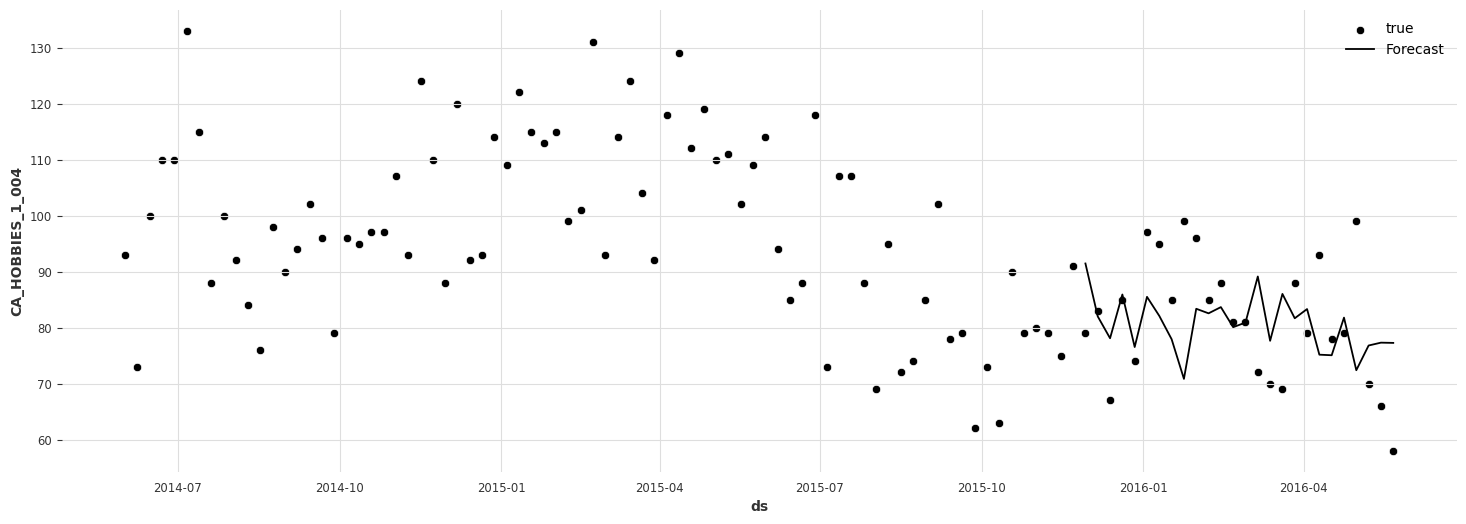

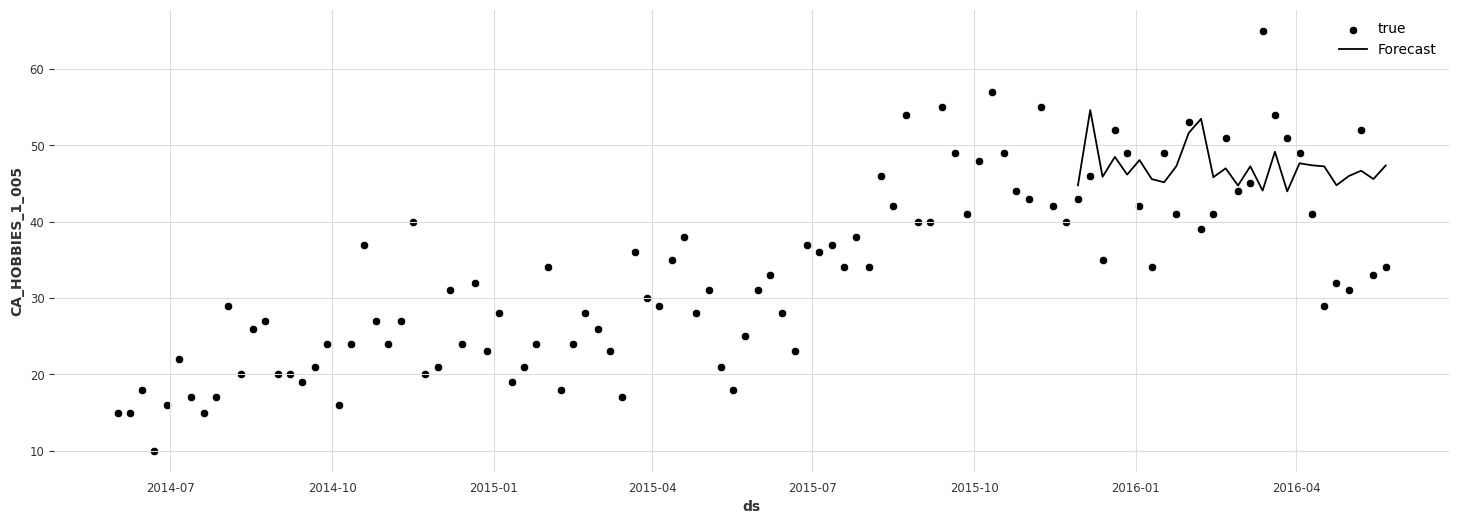

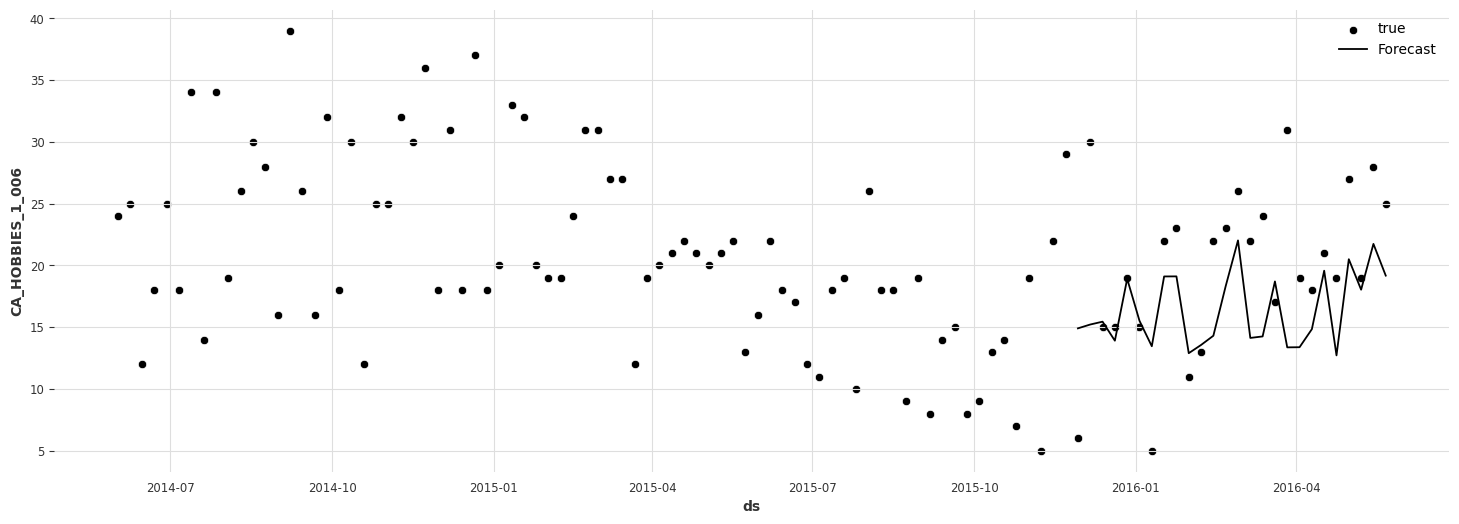

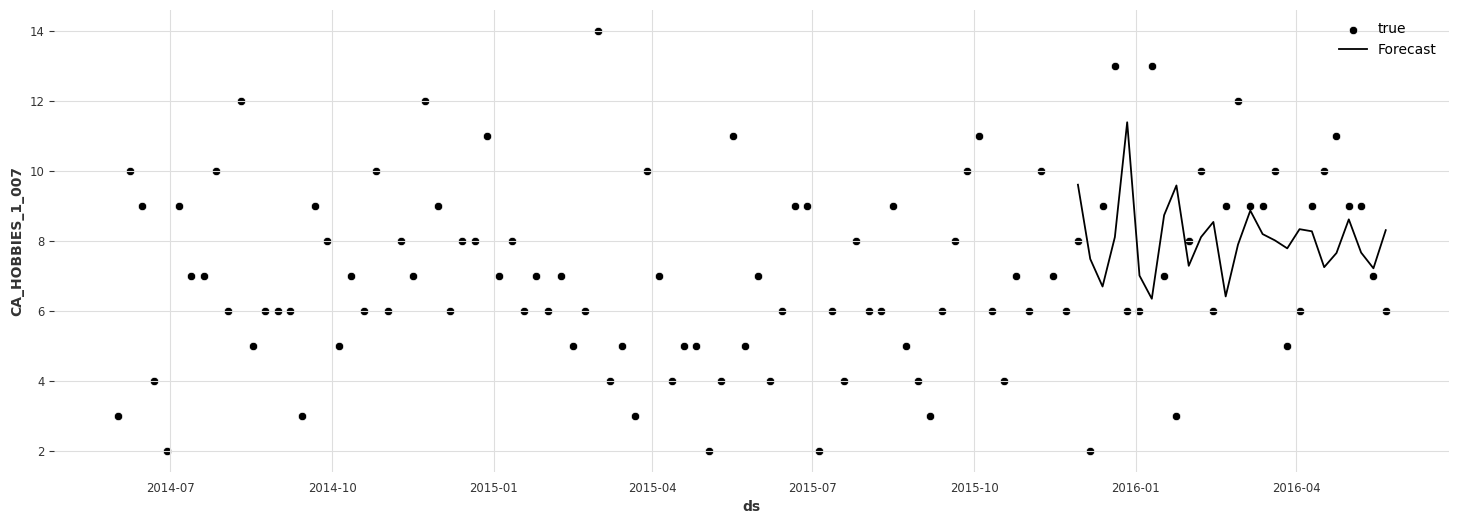

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in series_to_predict:
  plt.figure(figsize=(18,6))
  sns.scatterplot(x = data[i][-104:].index, y = data[i][-104:].values, label = 'true')
  sns.lineplot(data = forecast[i].pd_series(), label = 'Forecast')